# Case Study: CPA catalyzed addition to imines (Nature 2019)

Goal: Test if RCCR can uncover clusters that correspond to either +ee or -ee clusters from the original report

In [1]:
import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
plt.rcParams.update(plt.rcParamsDefault)

sys.path.append('../src')
import rccr

In [2]:
df = pd.read_excel('../data/Reid_Sigman_Nature.xlsx').dropna()

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,4:],df['ddG'], test_size=0.1, random_state=25)

y_abs = np.abs(y_train)
y_test_abs = np.abs(y_test)


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)
pcs = pca.transform(X_train_scaled)[:,:20]
pcs_test = pca.transform(X_test_scaled)[:,:20]

In [ ]:
cluster_list = []
average_r2_list = []
r2_list = []
full_r2 = []
for i in range(2,10):
    print(i)
    new_labels = rccr.get_average_clusters(pcs,y_abs.values,n_clusters=i,iterations=8,max_iteration_cluster=3, plot=False)
    cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_abs.values,labels=new_labels)
    full_r2.append(r2_score(cr_meas,cr_pred))
    temp = []
    for cluster in np.unique(clusters):
        index = clusters == cluster
        r2_list.append(r2_score(cr_meas[index[:,0]],cr_pred[index[:,0]]))
        cluster_list.append(i)
        temp.append(r2_score(cr_meas[index[:,0]],cr_pred[index[:,0]]))
    average_r2_list.append(np.average(temp))

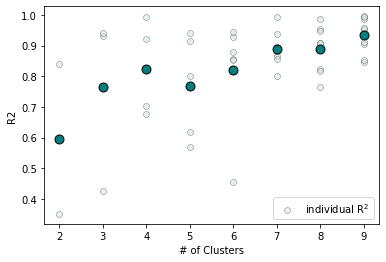

In [ ]:
sns.scatterplot(x=cluster_list,y=r2_list, color='#d1e0e0', edgecolors='black', alpha=0.5, label='individual R$^2$')
plt.scatter(range(2,10),average_r2_list, color='#008080', edgecolors='black', s=80, label='average R$^2$')
plt.xlabel('# of Clusters')
plt.ylabel('R2')
plt.show()

In [4]:
new_labels = rccr.get_average_clusters(pcs,y_abs.values,n_clusters=3,iterations=80,max_iteration_cluster=5, plot=False, num_jobs=-1)

Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Initial r2 0.2928375658204586
Iteration 0 0.5826933823246446
Iteration 0 0.6194638078320868
Iteration 0 0.6852881582098992
Iteration 0 0.592191326215581
Iteration 0 0.603504841607971
Iteration 0 0.6689044938988626
Iteration 0 0.618110996837392
Iteration 0 0.5908529269319773
Iteration 1 0.7158061084962174
Iteration 1 0.7007529700675473
Iteration 1 0.7101308122892652
Iteration 1 0.6930492368288288
Iteration 1 0.7623079656105963
Iteration 1 0.763778808959852
Iteration 1 0.7072834001248623
Iteration 1 0.7071800771816431
Iteration 2 0.7338276734735188
Iteration 2 0.7292151754436262
Iteration 2 0.7661118367269073
Iteration 2 0.7241745341354635
Iteration 2 0.7301655507122363
Iteration 2 0.7675060722991516
Iteration 2 0.7329297540688128
Iteration 2 0.7291588818636456
Iteration 3 0.736254

Cluster 0 R2 0.4234104484811043 coeff [0.13656420244806158][3] int 1.6378184012048087
Cluster 1 R2 0.9457386213117737 coeff [0.09017190128961189][1] int 0.739621177723865
Cluster 2 R2 0.9296101096857688 coeff [0.40417933373372833][12] int 1.730777647692187


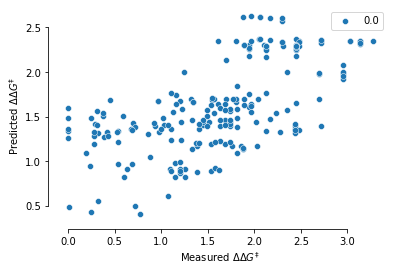

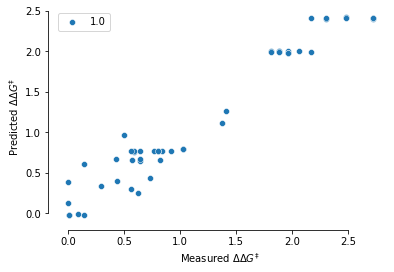

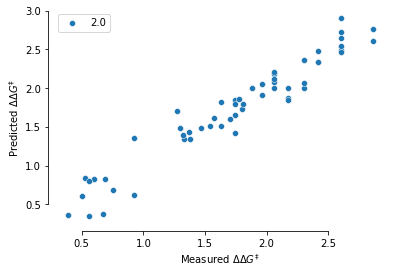

cr R2 0.6014060126310812


In [9]:
cr_meas, cr_pred, clusters = rccr.cr_fit(pcs,y_abs.values,labels=new_labels)

for cluster in np.unique(clusters):
    index = clusters ==  cluster
    sns.scatterplot(x=cr_meas[tuple([index[:,0]])],y=cr_pred[tuple([index[:,0]])], label=cluster)

    sns.despine(offset=5, trim=True)

    
    plt.xlabel('Measured $\Delta\Delta G^‡$')
    plt.ylabel('Predicted $\Delta\Delta G^‡$')
    plt.show()


print("cr R2 " + str(r2_score(cr_meas, cr_pred)))

In [10]:
array = rccr.get_possible_clusters(pcs,y_abs.values, labels=new_labels, scoring='MAE')

from sklearn.preprocessing import OneHotEncoder

new_labels_array = OneHotEncoder(sparse=False).fit_transform(new_labels.reshape(-1,1))

final_array = new_labels_array+array

final_array[final_array == 2] = 1


In [11]:
test_array = np.zeros(shape=(len(y_test),len(final_array[0])))
for cluster in range(0,len(final_array[0])):
    model = RandomForestClassifier().fit(X_train_scaled,final_array[:,cluster])
    test_labels = model.predict(X_test_scaled)
    test_array[:,cluster] = test_labels

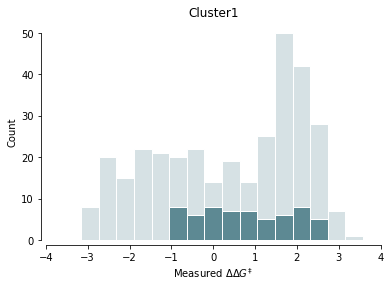

proportion greater than 0 = 0.65
minimum = -0.93


In [12]:
CLUSTER = 1 #Set to desired cluster for visualization

c_index = final_array[:,CLUSTER] == 1
c0_index = final_array[:,CLUSTER] == 0

sns.histplot(y_train,color='#346c78', edgecolor='white',alpha=0.2, bins=np.linspace(-4,4,20))
sns.histplot(y_train.loc[c_index], color='#346c78', edgecolor='white', bins=np.linspace(-4,4,20))
plt.xlim(-4,4)

plt.xlabel('Measured $\Delta\Delta G^‡$')
sns.despine(offset=5, trim=True)
plt.title('Cluster' + str(CLUSTER))
plt.show()

print('proportion greater than 0 = ' + str(sum(y_train.loc[c_index]>0)/len(y_train.loc[c_index])))
print('minimum = ' + str(min(y_train.loc[c_index])))